# Clustering with Zillow 
or
## ¯\\_(ツ)_/¯
By Joshua Mayes 08/07/2022

## About this notebook

### Goals

Zillow, a real-estate listing website, is looking to improve their model that predicts property value.  By applying a model that can accurately predict their model's error, they can adjust the predictions of their existing model, resulting in a more accurate prediction.

*Agile Story Format:*
> As a `real-estate listing website`, 
> I want `predictions of my model's logerror`
> so that I can `reduce my model's logerror`.

### Steps to reproduce
First download a copy of each file or clone this repository.

To run this project you will need to fulfill one of the following requirements:
 > An environment file named `env.py` in the same directory as the other files.  The enviornment file should be structured the same as below and should contain your unique credentials to CodeUp's SQL server.
 ```py
hostname='data.codeup.com'
username='your_username'
password='your_password'
```
> A csv file named `data.csv` in the same directory as the other files.  You can download a copy of the data from [Kaggle](https://www.kaggle.com/competitions/zillow-prize-1/data)

You will also need to ensure the proper libraries are installed in your python environment.  You can install the libraries easily by running the following command in your python shell:
```py
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install plotly
%pip install scipy
%pip install sklearn
```
___________

In [2]:
# Core DS libraries
import pandas as pd
import numpy as np
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Custom helper libraries
import wrangle
import my_toolkit
import model

## Executive Summary


Although throughout exploration I was able to find very weak corellations to `logerror` and was also able to develop some clusters that seemed to have some predictive power for `logerror`, I was unable to develop a model that meaninfully out-performed a baseline model.

### Recommendations

Because of the difficulty and lack of progress that was made during this project my recommendations are to either:
- Reassign the project to a more experienced data scientist, or to one with some expertise in the domain of real-estate pricing.  
or  
- Post a bounty on Kaggle
    - I am not confident that more time spent on this project will meaningfully improve my results.

### Model Performance


> **A note about sample nomenclature**  
> Because I disagree with the nomenclature set out in the course I am using a different naming convention.  
> _`Train`_ is for training the model  
> _`Test`_ is for testing the model's perfomance on unfit data  
> _`Validate`_ is for validating that the model's performance is consistent on never-seen-before data.


**Metrics Selection**:  
For evaluating these models I chose RMSE (Root Mean Squared Error) because it is both a widely accepted metric for evaluating regression models, and it is not sensitive to the sample size like SSE (Sum of Squared Errors) is.

#### Evaluating against out-of-sample data

Because of concerns of overfitting the only evaluation metrics that I was concerned with for determining model performance was those that were collected on the test sample-set.  After creating and evaluating several models I was unable to meaningfully improve on the baseline model.

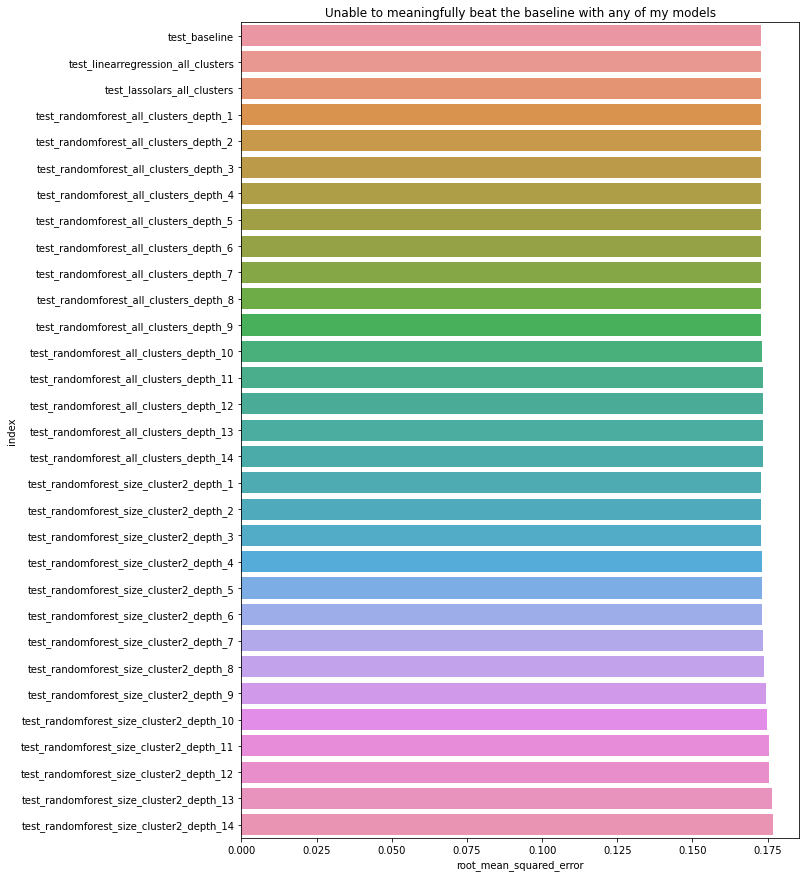

In [3]:
## Display a bar-plot that compares the RMSE for all models evaluated against test
plt.figure(figsize=(10,15))
plt.title('Unable to meaningfully beat the baseline with any of my models')
sns.barplot(data=model.df_test_metrics.reset_index(), y='index', x='root_mean_squared_error')
plt.show()

#### Evaluating against the final sample-set
> **Note** I am only doing this because it is required for the project.  If this were a real project none of my models would have been evaluated on the validate sample-set.

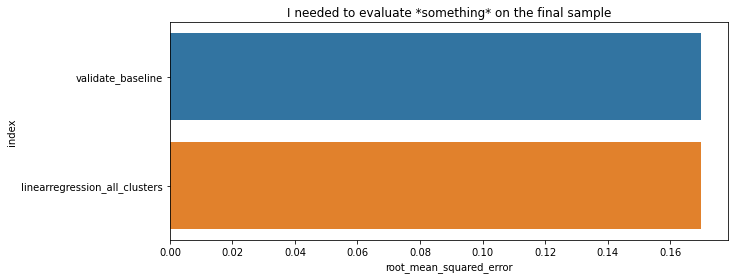

In [4]:
## Display a bar-plot that compares the RMSE for all models evaluated against validate
plt.figure(figsize=(10,4))
plt.title('I needed to evaluate *something* on the final sample')
sns.barplot(data=model.df_validate_metrics.reset_index(), y='index', x='root_mean_squared_error')
plt.show()

### Key Discoveries


This project was frustratingly void of any meaningul discoveries.  However, I still encountered some interesting behaviors and developed some promising clusters.

In [5]:
# Import the training dataset
df, _, __ = wrangle.wrangle_zillow()

# Scale the training dataset
xf = model.df_scale_cols(df, model.scale_cols, model.scaler1)

#### Strange interaction between the ratio of building value and overall value when compared to the lot's value.

I noticed that when I engineered a feature called `structure_tax_ratio`, which is calculated by $ Structure Value \div Overall Value $, and plot it against the Tax Value, there is a non-linear shape that emerges.  However, I was unable to determine why that happens, or how I might be able to use it as a predictive quality so the interaction remained unused.

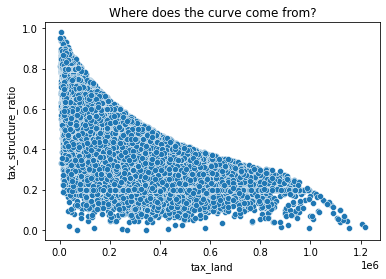

In [6]:
# Quickly engineer the feature
df['tax_structure_ratio'] = df.tax_structure / df.tax

# Plot the interaction to show off the curve
sns.scatterplot(data=df, x='tax_land', y='tax_structure_ratio')
plt.title('Where does the curve come from?')
plt.show()

#### Possibly useful clusters

During the exploration process I managed to pick out some clusters using K-means methods that seemed to have a strong interaction with logerror.  The method for recreating them is stored in my model helper.  I'll add them to our dataframe now.

In [7]:
# Assign clusters based on scaled data.
xf = model.df_add_clusters(xf, model.all_clusterers)
# Then reassign those clusters back to the unscaled data.
df['cluster1'] = xf.cluster1
df['cluster2'] = xf.cluster2
df['cluster3'] = xf.cluster3

##### Cluster 1 - [`Age`, `Tax`]

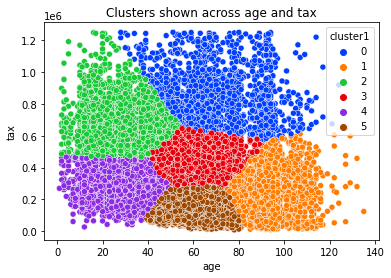

In [8]:
sns.scatterplot(data=df, x='age', y='tax', hue='cluster1', palette='bright')
plt.title('Clusters shown across age and tax')
plt.show()

Since this cluster is a 2 dimensional cluster it is easy to visualize and see how the data is grouped.  After the data has been clustered we can then use an ANOVA test to determine if our clustering was useful to predicting logerror.

In [9]:
my_toolkit.anova_variance_in_target_for_cat(df, 'logerror', 'cluster1')

{'reject': True,
 'h0': 'There is no variance in logerror between subsets of cluster1',
 'stat_name': 'F',
 'stat': 12.419124209324742,
 'p_value': 4.642363276059677e-12,
 'alpha': 0.5}

In this case we can reject the null hypothesis that the logerror doesn't vary between clusters.  This is further demonstrated by showing the average logerror for each cluster in a bar graph.

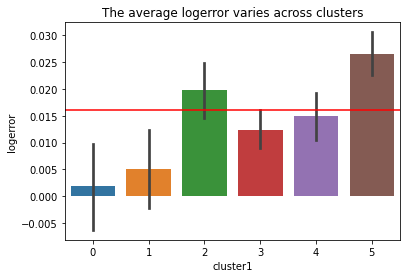

In [10]:
sns.barplot(data=df, y='logerror', x='cluster1')
plt.axhline(df.logerror.mean(), color='red')
plt.title('The average logerror varies across clusters')
plt.show()

In [11]:
model.cluster2_cols

['latitude', 'longitude', 'age', 'tax']

##### Cluster 2 - [`latitude`, `longitude`, `age`, `tax`]

Because this is a 4-dimensional cluster it doesn't make sense to try and represent it visually.  However, we can still ask the same statistical questions using ANOVA testing to determine if this cluster can be useful.

In [12]:
my_toolkit.anova_variance_in_target_for_cat(df, 'logerror', 'cluster2')

{'reject': True,
 'h0': 'There is no variance in logerror between subsets of cluster2',
 'stat_name': 'F',
 'stat': 9.692651689475142,
 'p_value': 2.9174737431703914e-09,
 'alpha': 0.5}

Again, we can reject the idea that there isn't any variance of logerror between these clusters.  

And again, we can visually confirm that in the same method.

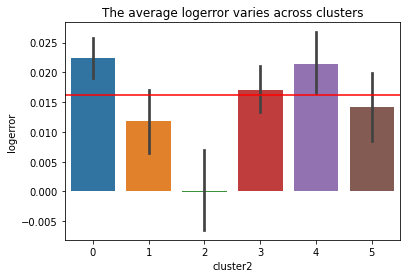

In [13]:
sns.barplot(data=df, y='logerror', x='cluster2')
plt.axhline(df.logerror.mean(), color='red')
plt.title('The average logerror varies across clusters')
plt.show()

Cluster 2 of Cluster2 is the most interesting here since its average logerror is right at 0, and its confidence interval only stretches .005 units in either direction.

#### Cluster 3 - [`latitude`, `longitude`, `structure_sqft`, `lot_sqft`]

With this cluster, although ANOVA testing shows a statistical significance in variance between clusters, the visualization did not seem to indicate a strong predictive power.

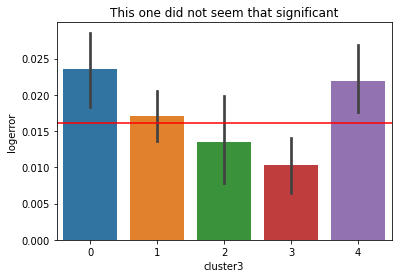

In [16]:
sns.barplot(data=df, y='logerror', x='cluster3')
plt.axhline(df.logerror.mean(), color='red')
plt.title('This one did not seem that significant')
plt.show()

In [17]:
my_toolkit.anova_variance_in_target_for_cat(df, 'logerror', 'cluster3')

{'reject': True,
 'h0': 'There is no variance in logerror between subsets of cluster3',
 'stat_name': 'F',
 'stat': 6.8849985933460705,
 'p_value': 1.556104718849705e-05,
 'alpha': 0.5}


## Conclusion
In conclusion: even though I was unable to glean any meaningful insights, or create any meaningful models, it was not due to lack of trying.  

### Summary
No strong drivers of logerror were discovered, and even though some clusters seemed to be strong predictors, they didn't have an impact on modeling.

### Next Steps
If I were to be asked to continue this project I would look at bringing more data into the equation, though I have no idea what kind of data would be useful.  
I would also look at more sophisticated machine learning algorithms or exploration techniques that I do not have a strong grasp on just yet.


## Process Documentation

## Getting the data

The first step in our DS pipeline is to import and understand the data we will be working with.  I have created a helper library (`wrangle.py`) to make the process easy and reproducible.  But to help you understand what's happening behind the scenes I'll demonstrate some of the steps that were taken.

#### Querying from SQL

In [27]:
df = wrangle.get_data()
df.shape

(52442, 68)

Already our helper library is helping quite a bit.  What just happened her was that our credentials to the SQL server was loaded from a file, and a predefined query was executed and the returned data loaded into Pandas.  The SQL Query narrows down the dataset to include only properties labeled as single family homes that had a transaction during the year 2017.

We can see that our new dataframe consists of 52442 rows and 68 columns.  That's a lot to work with.  Unfortunately, a large portion of the data is empty, with some of the columns being completely filled with nulls.

<AxesSubplot:title={'center':'Percentage of null values across columns'}>

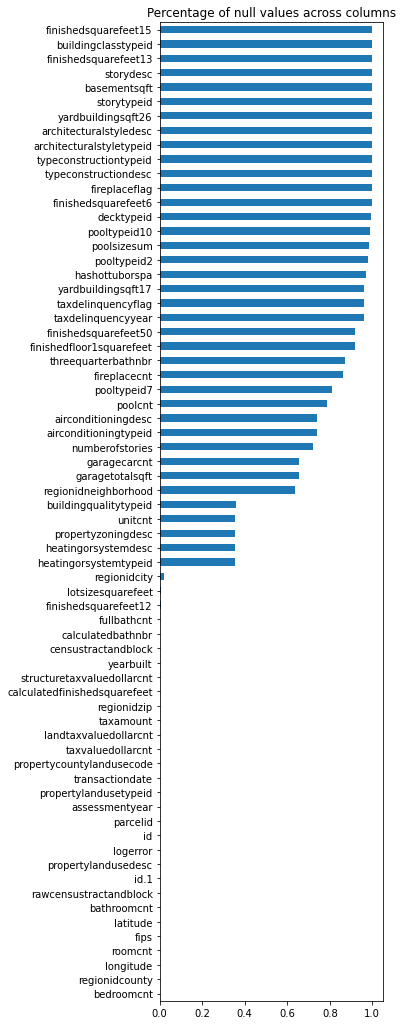

In [28]:
fig = plt.figure(figsize=(4,18))
df.isna().mean().sort_values().plot(kind='barh', title='Percentage of null values across columns')

#### Understanding what is here
To facilitate informed decisions on which columns to keep and which to drop, a data dictionary was created.
| Original Column Name | Renamed Column Name | Status | Notes | Column Description |
|---|---|---|---|---|
| '`airconditioningtypeid`' |  | Dropped | Too many nulls |  Type of cooling system present in   the home (if any) |
| '`architecturalstyletypeid`' |  | Dropped | 99.8% Null |  Architectural style of the home   (i.e. ranch, colonial, split-level, etc…) |
| '`assessmentyear`' |  | Dropped | All values the same | The year of the property tax assessment  |
| '`basementsqft`' |  | Dropped | 99.9% Null |  Finished living area below or   partially below ground level |
| '`bathroomcnt`' |  | Dropped | Duplicates 'calc_bath' |  Number of bathrooms in home   including fractional bathrooms |
| '`bedroomcnt`' |  | Kept |  |  Number of bedrooms in home  |
| '`buildingclasstypeid`' |  | Dropped | 100% Null | The building framing type (steel frame, wood frame, concrete/brick)  |
| '`buildingqualitytypeid`' |  | Dropped | Too many nulls |  Overall assessment of condition of   the building from best (lowest) to worst (highest) |
| '`calculatedbathnbr`' | `calc_bath` | Kept |  |  Number of bathrooms in home   including fractional bathroom |
| '`calculatedfinishedsquarefeet`' | `structure_sqft` | Kept |  |  Calculated total finished living   area of the home  |
| '`censustractandblock`' |  | Dropped | Same data as lat/long + fips |  Census tract and block ID combined   - also contains blockgroup assignment by extension |
| '`decktypeid`' |  | Dropped | 99% Null | Type of deck (if any) present on parcel |
| '`finishedfloor1squarefeet`' |  | Dropped | Too many nulls |  Size of the finished living area   on the first (entry) floor of the home |
| '`finishedsquarefeet12`' |  | Dropped | Same as structure_sqft | Finished living area |
| '`finishedsquarefeet13`' |  | Dropped | 100% Null | Perimeter  living area |
| '`finishedsquarefeet15`' |  | Dropped | 100% Null | Total area |
| '`finishedsquarefeet50`' |  | Dropped | Too many nulls |  Size of the finished living area   on the first (entry) floor of the home |
| '`finishedsquarefeet6`' |  | Dropped | 99% Null | Base unfinished and finished area |
| '`fips`' |  | Kept |  |  Federal Information Processing   Standard code -  see   https://en.wikipedia.org/wiki/FIPS_county_code for more details |
| '`fireplacecnt`' |  | Dropped | Too many nulls |  Number of fireplaces in a home (if   any) |
| '`fireplaceflag`' |  | Dropped | 99.8% Null |  Is a fireplace present in this   home  |
| '`fullbathcnt`' |  | Kept |  |  Number of full bathrooms (sink,   shower + bathtub, and toilet) present in home |
| '`garagecarcnt`' |  | Dropped | Too many nulls |  Total number of garages on the lot   including an attached garage |
| '`garagetotalsqft`' |  | Dropped | Too many nulls |  Total number of square feet of all   garages on lot including an attached garage |
| '`hashottuborspa`' |  | Dropped | Too many nulls |  Does the home have a hot tub or   spa |
| '`heatingorsystemtypeid`' |  | Kept | Nulls imputed as 2 (Central) |  Type of home heating system |
| '`landtaxvaluedollarcnt`' | `tax_land` | Kept | Hoping to use in ensemble model | The assessed value of the land area of the parcel |
| '`latitude`' |  | Kept | Perhaps the most trustworthy datapoint in the set |  Latitude of the middle of the   parcel multiplied by 10e6 |
| '`longitude`' |  | Kept | Perhaps the most trustworthy datapoint in the set |  Longitude of the middle of the   parcel multiplied by 10e6 |
| '`lotsizesquarefeet`' | `lot_sqft` | Kept |  |  Area of the lot in square feet |
| '`numberofstories`' |  | Dropped | Too many nulls |  Number of stories or levels the   home has |
| '`parcelid`' |  | Kept |  |  Unique identifier for parcels   (lots)  |
| '`poolcnt`' |  | Dropped | Too many nulls |  Number of pools on the lot (if   any) |
| '`poolsizesum`' |  | Dropped | Too many nulls |  Total square footage of all pools   on property |
| '`pooltypeid10`' |  | Dropped | 99% Null |  Spa or Hot Tub |
| '`pooltypeid2`' |  | Dropped | Too many nulls |  Pool with Spa/Hot Tub |
| '`pooltypeid7`' |  | Dropped | Too many nulls |  Pool without hot tub |
| '`propertycountylandusecode`' |  | Dropped | Difficult to derive meaning from |  County land use code i.e. it's   zoning at the county level |
| '`propertylandusetypeid`' |  | Dropped | All values the same |  Type of land use the property is   zoned for |
| '`propertyzoningdesc`' |  | Dropped | Too many nulls |  Description of the allowed land   uses (zoning) for that property |
| '`rawcensustractandblock`' |  | Dropped | Same data as lat/long + fips |  Census tract and block ID combined   - also contains blockgroup assignment by extension |
| '`regionidcity`' |  | Kept |  |  City in which the property is   located (if any) |
| '`regionidcounty`' |  | Dropped | Duplicates fips | County in which the property is located |
| '`regionidneighborhood`' |  | Dropped | Too many nulls | Neighborhood in which the property is located |
| '`regionidzip`' |  | Kept |  |  Zip code in which the property is   located |
| '`roomcnt`' |  | Kept |  |  Total number of rooms in the   principal residence |
| '`storytypeid`' |  | Dropped | 99.9% Null |  Type of floors in a multi-story   house (i.e. basement and main level, split-level, attic, etc.).  See tab for details. |
| '`structuretaxvaluedollarcnt`' | `tax_structure` | Kept | Hoping to use in ensemble model | The assessed value of the built structure on the parcel |
| '`taxamount`' |  | Dropped | Leaks data about target variable | The total property tax assessed for that assessment year |
| '`taxdelinquencyflag`' |  | Kept | Made into Boolean with Null imputed as false | Property taxes for this parcel are past due as of 2015 |
| '`taxdelinquencyyear`' |  | Engineered | See 'years_tax_delinquent' | Year for which the unpaid propert taxes were due  |
| '`taxvaluedollarcnt`' | `tax` | Target | This is our target variable | The total tax assessed value of the parcel |
| '`threequarterbathnbr`' |  | Dropped | Too many nulls |  Number of 3/4 bathrooms in house   (shower + sink + toilet) |
| '`typeconstructiontypeid`' |  | Dropped | 99.8% Null |  What type of construction material   was used to construct the home |
| '`unitcnt`' |  | Kept | Nulls imputed as 1 |  Number of units the structure is   built into (i.e. 2 = duplex, 3 = triplex, etc...) |
| '`yardbuildingsqft17`' |  | Dropped | Too many nulls | Patio in  yard |
| '`yardbuildingsqft26`' |  | Dropped | 99.8% Null | Storage shed/building in yard |
| '`yearbuilt`' |  | Kept | Also engineered. See 'age' |  The Year the principal residence   was built  |
|  | `years_tax_delinquent` | Engineered | Nulls imputed as 0 | Calculated by subtacting 'taxdelinquencyyear' from 2017 |
|  | `age` | Engineered |  | Calculated by subtracting 'yearbuilt' from 2017 |
|  | `bathroom_sum` | Engineered |  | Calculated by taking 3/4 of 'threequarterbathnbr' and adding it to   'fullbathcnt' |
| `logerror` |  | Dropped | Leaks data about target variable | Log of the error produced by Zillows existing model |
| `transactiondate` |  | Dropped | Not useful in context of this project | Date of the transaction which zillow's model compared its prediction |                                                 |


#### Saving the columns I can

After diving into each column I was able to come up with a strategy to preserve the data for three of them.
- **`taxdelinquencyflag`**
    - Converted to Boolean where Y = True and Null = False
- **`taxdelinquencyyear`**
    - Created a new column `years_tax_delingquent` by assuming that Nulls == 0 and subtracting the row from 2017 (The year from which this dataset is derived.)
- **`threequarterbathnbr`**
    - Although I didn't actually save the column, I noticed that in some cases there were more threequarter bathrooms than there were bathrooms in the bathroomcnt column.  Hoping that this data might improve my model's accuracy I decided to preserve it by creating a new column: `bathroom_sum`, which is the sum of three quarter bathrooms and full bathrooms.
- **`unitcnt`**
    - An overwhelming majority of rows had the value of "1". So I filled each null with "1".
- **`heatingorsystemdesc`**
    - Similar to `unitcnt`, there was an overwhelming majority of "Central". So I filled each null with "Central" as well.

#### Dropping what I can't

After investigating each column and evaluating whether it could be used or not, a vast majority of them were difficult to trust their accuracy or difficult to find an imputing method that I could be confident in.  As a result, any remaining column with a null percentage higher than 34% was dropped.

Additionally, there were several columns that weren't riddled with nulls but were ultimately unuseful or undesired.  These columns were:
- `id`
- `id.1`
- `assessmentyear`
- `bathroomcnt`
- `finishedsquarefeet12`
- `logerror`
- `propertycountylandusecode`
- `propertylandusedesc`
- `propertylandusetypeid`
- `rawcensustractandblock`
- `censustractandblock`
- `regionidcounty`
- `transactiondate`
- `taxamount`

#### The rest of the nulls
At this point most, but not all, of the data is null free.  To correct that the rows with any remaining nulls were dropped from the dataset.

#### My helper function helps again.

In [29]:
df = wrangle.clean_zillow(df)
df.shape

(50163, 23)

<AxesSubplot:title={'center':'Percentage of null values across columns'}>

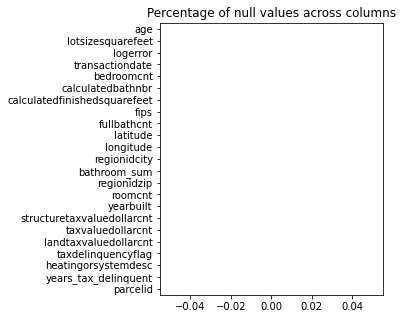

In [30]:
fig = plt.figure(figsize=(4,5))
df.isna().mean().sort_values().plot(kind='barh', title='Percentage of null values across columns')

## Trimming the Data
After handling all of the null values we are left with 50747 rows across 22 columns.  Each row represents a property in Los Angeles and the surrounding area across three different counties.

In [31]:
import plotly.express as px
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",
                    color="fips", 
                    opacity=.3,
                    size_max=.5, zoom=7)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":20,"t":0,"l":0,"b":0})
fig.update_layout(width=800, height= 700)
fig.show()

### Bad Data (IE. Rabbit hole city)
Still there is a bit more work to do in trimming the data.  In my hunt for outliers I came across a few records that seemed erroneous.  Take for example this row which was the proud owner of the smallest lot size in the dataset.

In [32]:
df[df.lotsizesquarefeet < 400][['parcelid','latitude','longitude','lotsizesquarefeet','calculatedfinishedsquarefeet']]

,parcelid,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet


Thankfully location data is included in the dataset so I was able to hunt down the property on Google maps and judge if it really did have such a small lot.  
There is no way that's a 236 sqft lot.  
![image](https://i.imgur.com/gTNnAfU.png)

The dataset is rife with examples like this.  For example, several datapoints have 0 bedrooms.

In [33]:
df[df.bedroomcnt == 0].head()[['parcelid','latitude','longitude','bedroomcnt','calculatedfinishedsquarefeet']]

,parcelid,latitude,longitude,bedroomcnt,calculatedfinishedsquarefeet


#### Abandoning the rabbit holes
Unfortunately the time alloted for this project is limited, so I decided to stop my investigation there and just accept the fact that I'm probably working with bad data.  However, I want my model to represent reality and not the bad data that it was trained on, so I made some rules to trim out these kinds of data-points.

### The hunt for outliers

I knew walking into this project that there were some pretty offensive outliers in the dataset.  So I wanted to make sure that I trimmed some off.  However, I knew we were going to be training a model on the dataset so it was going to be important to split the data first.  This is to avoid data leakage.

> Note: I realized I made a mistake earlier by hunting down bad data before I split the data, so I later went back and changed my script to apply those rules after the data split happens.

In [34]:
df, _, __ = wrangle.train_test_validate_split(df)
df.shape

(30097, 23)

After splitting the dataset into three groups I'm left with 60% of my original data.  It's on this training data that I will trim outliers and bad data.  However, I will be leaving the other two datasets alone because even though I'm trying to make my model represent reality, it will still be predicting on the bad data in Zilows databases.

I wound up trimming outliers from the following, using the 99th percentile as a cutoff point:
- `taxvaluedollarcnt`
- `calculatedfinishedsquarefeet`
- `lotsizesquarefeet`